In [2]:
from geostat import GP, Model, Mesh, Parameters
import geostat
import geostat.kernel as krn
import matplotlib.pyplot as pp
import numpy as np
import tensorflow as tf

# Overview

In this notebook we will:
  * Use a Gaussian process with a complex stacked covariance function to generate synthetic data.
  * Use Gaussian processes with covariance functions of increasing complexity to infer the geospatial parameters from the synthetic data. Each time, log likelihood improves and the nugget decreases. A smaller nugget means that predictions are more confident.

# Synthesizing data

We will synthesize data at random locations in 3D space near the origin.

In [3]:
np.random.seed(111)

locs = np.random.normal(size=[500, 3]) * [1., 1., 0.333]

There will be a cubic depth trend, but no horizontal trends. The decorator converts the function `trend_featurizer` into a featurizer that Geostat can use. The `normalize` argument causes each feature to have zero mean and unit variance after being applied to the given locations. It also adds a constant one feature.

In [4]:
@geostat.featurizer(normalize=locs.reshape([-1, 3]))
def trend_featurizer(x, y, z): return z, z*z, z*z*z

Model parameters are specified here, along with their values. The return value `p` is a namespace.

In [5]:
p = Parameters(alpha=0.1, zs=10., r=0.33, s1=1., s2=0.5, g1=1., g2=0.5, nugget=0.25)

The covariance function will include a trend based on the featurizer, and will combine two gamma-exponentials: one that respects depth with z-anisotropy, and one that ignores depth altogether. We will set the `range` for both to be the same parameter to show that it is possible to tie parameters together. In `TrendPrior`, `alpha` parameterizes the normal distribution prior for trend coefficients. 

In [6]:
kernel = \
    krn.TrendPrior(trend_featurizer, alpha=p.alpha) + \
    krn.GammaExponential(range=p.r, sill=p.s1, gamma=p.g1, scale=[1., 1., p.zs]) + \
    krn.GammaExponential(range=p.r, sill=p.s2, gamma=p.g2, scale=[1., 1., 0.]) + \
    krn.Noise(p.nugget)

Define a Gaussian process with zero mean and a covariance function given by `kernel`.

In [7]:
gp = GP(0, kernel)

Instantiate a `Model` and immediately call `generate` to generate synthetic observations.

In [8]:
tf.random.set_seed(113)

obs = Model(gp).generate(locs).vals

When the data is plotted, you can see an overall trend with some localized variations.

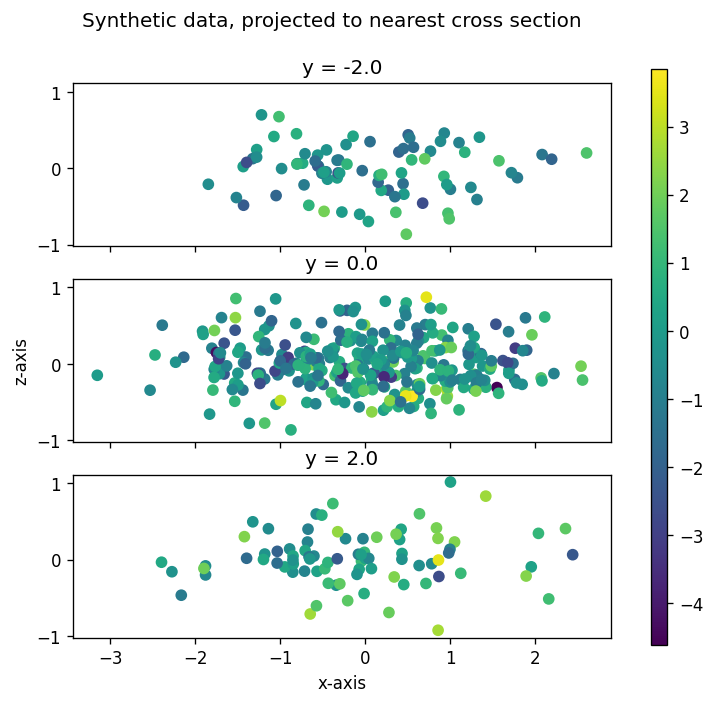

In [9]:
fig, axs = pp.subplots(3, figsize=(7, 6), dpi=120, sharex=True, sharey=True)
vmin, vmax = obs.min(), obs.max()
pane = np.round((locs[:, 1] + 2) / 2).astype(int)
for i, ymid in enumerate(np.linspace(-2, 2, 3)):
    ymin, ymax = ymid - 1, ymid + 1
    c = axs[i].scatter(locs[pane == i, 0], locs[pane == i, 2], c=obs[pane == i], vmin=vmin, vmax=vmax)
    axs[i].set_title('y = %0.1f' % ymid)
    axs[i].set_aspect(0.9)
axs[2].set_xlabel('x-axis')
axs[1].set_ylabel('z-axis')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.88, 0.1, 0.02, 0.8])
fig.colorbar(c, cax=cbar_ax)

fig.suptitle('Synthetic data, projected to nearest cross section')
pp.show()

Before we continue, let's define a function that takes a model and plots predictions for the three slices shown above.

In [10]:
def plot(model):
    fig, axs = pp.subplots(3, figsize=(7, 6), dpi=120, sharex=True, sharey=True)
    for i, ymid in enumerate(np.linspace(-2, 2, 3)):

        mesh = Mesh.from_bounds([-3, -1, 3, 1], nx=200)
        mesh_locs = mesh.locations(proj=[[1, 0, 0], [0, 0, 1], [0, ymid, 0]]) # [x, z, 1] -> [x, y, z].
        mean, var = model.predict(mesh_locs)
        meshx, meshy, out = mesh.slice(mean)
        c = axs[i].pcolormesh(meshx, meshy, out, vmin=vmin, vmax=vmax)

        axs[i].set_title('y = %0.1f' % ymid)
        axs[i].set_aspect(0.9)
    axs[2].set_xlabel('x-axis')
    axs[1].set_ylabel('z-axis')

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.88, 0.1, 0.02, 0.8])
    fig.colorbar(c, cax=cbar_ax)

    fig.suptitle('Predictions for 3 cross sections')
    pp.show()

# Model 1: Bayesian regression

First let's try modeling the data with a Bayesian regression, which is a model with just trends and uncorrelated noise.

In [11]:
p = Parameters(alpha=1.0, nugget=0.5)

kernel = krn.TrendPrior(trend_featurizer, alpha=p.alpha) + krn.Noise(nugget=p.nugget)

model1 = Model(GP(0, kernel)).fit(locs, obs, iters=500)

[iter    50 ll -910.60 time  1.73 reg  0.00 alpha  0.61 nugget  0.79]
[iter   100 ll -853.59 time  0.69 reg  0.00 alpha  0.37 nugget  1.06]
[iter   150 ll -836.20 time  0.69 reg  0.00 alpha  0.23 nugget  1.28]
[iter   200 ll -830.86 time  0.68 reg  0.00 alpha  0.15 nugget  1.42]
[iter   250 ll -829.16 time  0.69 reg  0.00 alpha  0.10 nugget  1.50]
[iter   300 ll -828.57 time  0.68 reg  0.00 alpha  0.07 nugget  1.54]
[iter   350 ll -828.35 time  0.69 reg  0.00 alpha  0.06 nugget  1.56]
[iter   400 ll -828.27 time  0.68 reg  0.00 alpha  0.05 nugget  1.57]
[iter   450 ll -828.25 time  0.69 reg  0.00 alpha  0.04 nugget  1.58]
[iter   500 ll -828.24 time  0.68 reg  0.00 alpha  0.04 nugget  1.58]


And here are predictions for the three slices shown above.

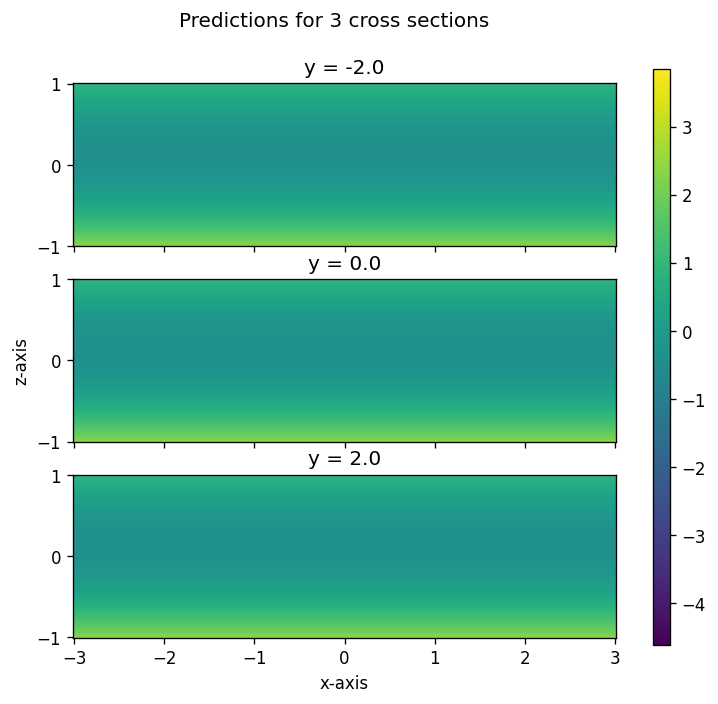

In [12]:
plot(model1)

# Model 2: GP with isotropic sq-exp covariance function

Now let's layer on an isotropic squared exponential covariance function to the above model.

In [15]:
p = Parameters(alpha=1.0, range=1.0, sill=0.5, nugget=0.5)

kernel = \
    krn.TrendPrior(trend_featurizer, alpha=p.alpha) + \
    krn.SquaredExponential(range=p.range, sill=p.sill) + \
    krn.Noise(nugget=p.nugget)

model2 = Model(GP(0, kernel)).fit(locs, obs, iters=500)

[iter    50 ll -864.77 time  1.41 reg  0.00 alpha  0.61 sill  0.75 range  0.62 nugget  0.77]
[iter   100 ll -829.58 time  0.80 reg  0.00 alpha  0.37 sill  0.53 range  0.46 nugget  0.99]
[iter   150 ll -820.58 time  0.80 reg  0.00 alpha  0.23 sill  0.38 range  0.40 nugget  1.13]
[iter   200 ll -817.97 time  0.80 reg  0.00 alpha  0.15 sill  0.33 range  0.38 nugget  1.22]
[iter   250 ll -816.98 time  0.80 reg  0.00 alpha  0.10 sill  0.31 range  0.38 nugget  1.27]
[iter   300 ll -816.48 time  0.80 reg  0.00 alpha  0.07 sill  0.30 range  0.38 nugget  1.29]
[iter   350 ll -816.18 time  0.80 reg  0.00 alpha  0.05 sill  0.29 range  0.39 nugget  1.31]
[iter   400 ll -816.00 time  0.80 reg  0.00 alpha  0.04 sill  0.28 range  0.40 nugget  1.32]
[iter   450 ll -815.90 time  0.80 reg  0.00 alpha  0.04 sill  0.27 range  0.42 nugget  1.33]
[iter   500 ll -815.84 time  0.80 reg  0.00 alpha  0.03 sill  0.27 range  0.43 nugget  1.33]


The log-likelihood is improved as a result of a more complex model. Nugget is much lower. Predictions:

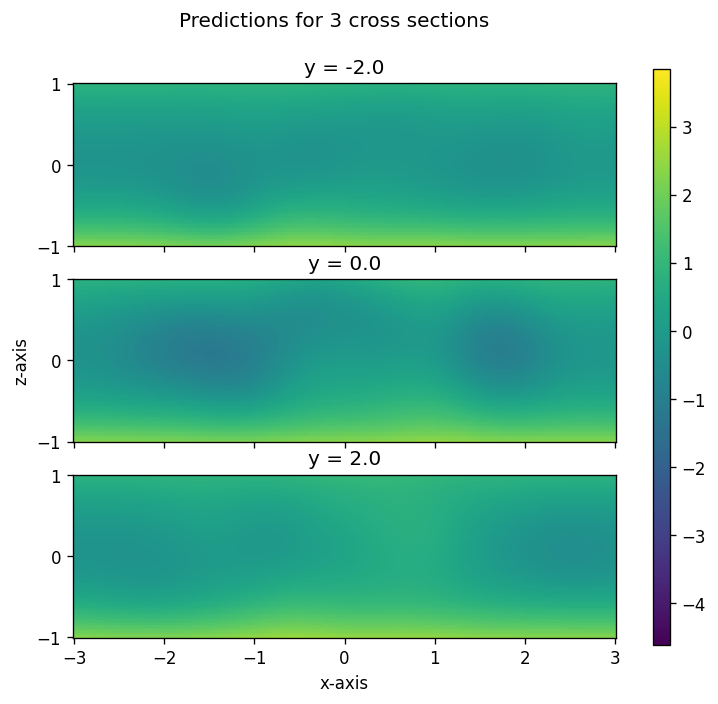

In [16]:
plot(model2)

# Model 3: GP with anisotropic sq-exp covariance function

Now we switch from isotropic to anisotropic for the covariance function.

In [17]:
p = Parameters(alpha=1.0, range=1.0, sill=0.5, nugget=0.5, zs=5.0)

kernel = \
    krn.TrendPrior(trend_featurizer, alpha=p.alpha) + \
    krn.SquaredExponential(range=p.range, sill=p.sill, scale=[1., 1., p.zs]) + \
    krn.Noise(nugget=p.nugget)

model3 = Model(GP(0, kernel)).fit(locs, obs, iters=500)

[iter    50 ll -841.04 time  1.50 reg  0.00 alpha  0.61 zs  7.43 sill  0.75 range  0.65 nugget  0.76]
[iter   100 ll -821.03 time  0.86 reg  0.00 alpha  0.37 zs  8.75 sill  0.74 range  0.50 nugget  0.90]
[iter   150 ll -817.17 time  0.86 reg  0.00 alpha  0.23 zs  8.73 sill  0.66 range  0.43 nugget  0.95]
[iter   200 ll -815.63 time  0.86 reg  0.00 alpha  0.15 zs  8.13 sill  0.63 range  0.39 nugget  0.97]
[iter   250 ll -814.62 time  0.86 reg  0.00 alpha  0.10 zs  7.37 sill  0.63 range  0.37 nugget  0.98]
[iter   300 ll -813.89 time  0.87 reg  0.00 alpha  0.07 zs  6.66 sill  0.63 range  0.36 nugget  0.97]
[iter   350 ll -813.41 time  0.87 reg  0.00 alpha  0.05 zs  6.08 sill  0.64 range  0.35 nugget  0.97]
[iter   400 ll -813.12 time  0.87 reg  0.00 alpha  0.04 zs  5.64 sill  0.65 range  0.34 nugget  0.96]
[iter   450 ll -812.97 time  0.87 reg  0.00 alpha  0.04 zs  5.32 sill  0.66 range  0.33 nugget  0.95]
[iter   500 ll -812.89 time  0.87 reg  0.00 alpha  0.04 zs  5.11 sill  0.67 range 

Log-likelihood and nugget both improve further. Predictions:

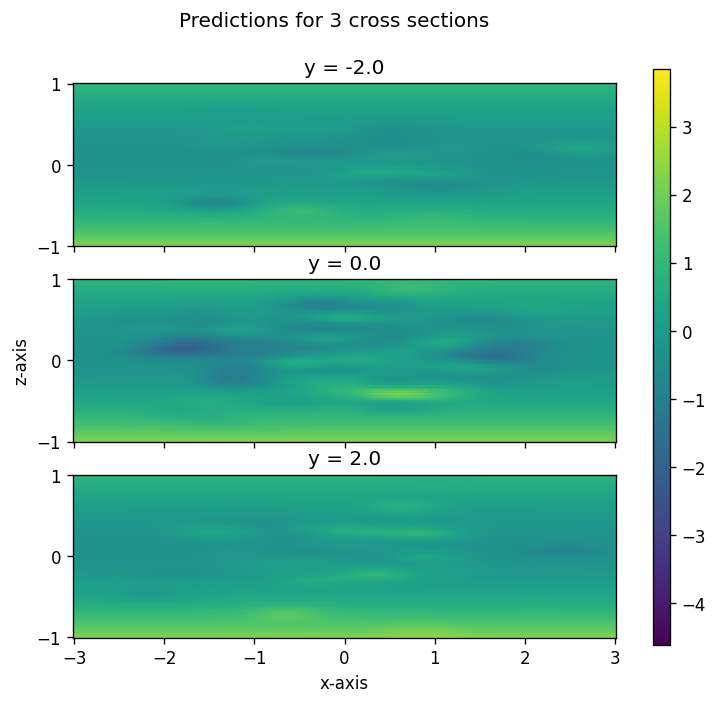

In [18]:
plot(model3)

# Model 4: GP with anisotropic gamma-exp covariance function

Now we switch from a squared-exponential to a gamma-exponential covariance function, which has an extra shape parameter.

In [19]:
p = Parameters(alpha=1.0, range=1.0, sill=0.5, nugget=0.5, zs=5.0, gamma=1.0)

kernel = \
    krn.TrendPrior(trend_featurizer, alpha=p.alpha) + \
    krn.GammaExponential(range=p.range, sill=p.sill, gamma=p.gamma, scale=[1., 1., p.zs]) + \
    krn.Noise(nugget=p.nugget)

model4 = Model(GP(0, kernel)).fit(locs, obs, iters=500)

[iter    50 ll -819.50 time  1.83 reg  0.00 alpha  0.61 zs  7.16 sill  0.76 range  0.67 gamma  0.84 nugget  0.74]
[iter   100 ll -815.43 time  0.94 reg  0.00 alpha  0.37 zs  6.94 sill  0.86 range  0.58 gamma  0.81 nugget  0.82]
[iter   150 ll -814.43 time  0.94 reg  0.00 alpha  0.23 zs  6.19 sill  0.87 range  0.56 gamma  0.81 nugget  0.82]
[iter   200 ll -813.66 time  0.94 reg  0.00 alpha  0.15 zs  5.77 sill  0.87 range  0.53 gamma  0.80 nugget  0.82]
[iter   250 ll -813.07 time  0.94 reg  0.00 alpha  0.10 zs  5.56 sill  0.86 range  0.50 gamma  0.80 nugget  0.82]
[iter   300 ll -812.64 time  0.94 reg  0.00 alpha  0.07 zs  5.45 sill  0.86 range  0.48 gamma  0.81 nugget  0.81]
[iter   350 ll -812.36 time  0.95 reg  0.00 alpha  0.05 zs  5.39 sill  0.86 range  0.46 gamma  0.82 nugget  0.80]
[iter   400 ll -812.19 time  0.95 reg  0.00 alpha  0.04 zs  5.36 sill  0.86 range  0.45 gamma  0.83 nugget  0.79]
[iter   450 ll -812.10 time  0.95 reg  0.00 alpha  0.04 zs  5.33 sill  0.86 range  0.43 

The log-likelihood has improved very slightly but nugget improves more significantly, since the pointy peak in the gamma-exponential does some of the work of a nugget. Predictions:

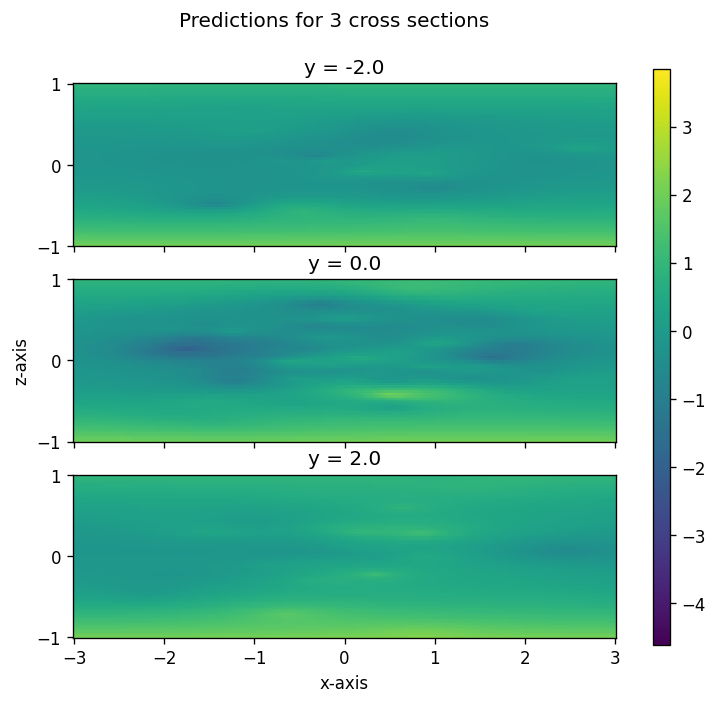

In [20]:
plot(model4)

# Model 5: GP with stacked covariance functions

Finally we switch to using the same covariance function used to generate the synthetic data.

In [21]:
p = Parameters(alpha=1., zs=5., r=0.5, s1=2., s2=1., g1=1., g2=1., nugget=1.)

kernel = \
    krn.TrendPrior(trend_featurizer, alpha=p.alpha) + \
    krn.GammaExponential(range=p.r, sill=p.s1, gamma=p.g1, scale=[1., 1., p.zs]) + \
    krn.GammaExponential(range=p.r, sill=p.s2, gamma=p.g2, scale=[1., 1., 0.]) + \
    krn.Noise(nugget=p.nugget)

model5 = Model(GP(0, kernel)).fit(locs, obs, iters=500)

[iter    50 ll -824.02 time  2.05 reg  0.00 alpha  0.61 zs  4.04 s1  1.32 r  0.75 g1  0.85 s2  0.65 g2  1.16 nugget  0.67]
[iter   100 ll -816.07 time  1.10 reg  0.00 alpha  0.38 zs  6.56 s1  1.11 r  0.81 g1  0.57 s2  0.50 g2  1.00 nugget  0.62]
[iter   150 ll -813.38 time  1.10 reg  0.00 alpha  0.24 zs  8.73 s1  1.02 r  0.79 g1  0.45 s2  0.43 g2  0.79 nugget  0.60]
[iter   200 ll -812.33 time  1.10 reg  0.00 alpha  0.16 zs  9.27 s1  0.97 r  0.74 g1  0.41 s2  0.39 g2  0.63 nugget  0.59]
[iter   250 ll -811.74 time  1.11 reg  0.00 alpha  0.11 zs  9.15 s1  0.94 r  0.67 g1  0.42 s2  0.38 g2  0.57 nugget  0.59]
[iter   300 ll -811.27 time  1.11 reg  0.00 alpha  0.08 zs  9.08 s1  0.91 r  0.60 g1  0.45 s2  0.38 g2  0.54 nugget  0.58]
[iter   350 ll -810.74 time  1.11 reg  0.00 alpha  0.06 zs  9.15 s1  0.88 r  0.52 g1  0.52 s2  0.37 g2  0.54 nugget  0.57]
[iter   400 ll -809.82 time  1.10 reg  0.00 alpha  0.05 zs  9.39 s1  0.82 r  0.43 g1  0.66 s2  0.37 g2  0.54 nugget  0.56]
[iter   450 ll -

Not surprisingly, log likelihood and nugget both improve further. You can see faint vertical stripes that correspond the the "depth-invariant" component of the covariance function.

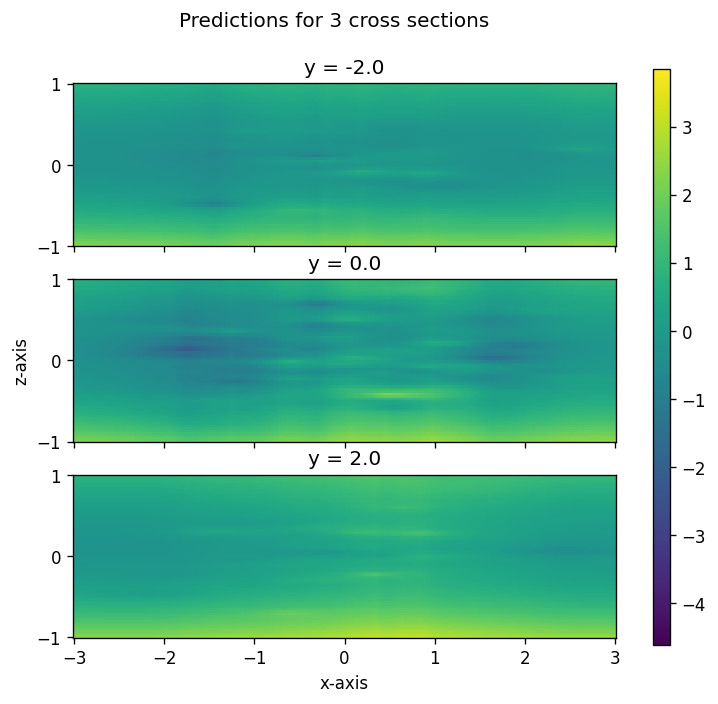

In [22]:
plot(model5)